In [ ]:
!sudo add-apt-repository ppa:alex-p/tesseract-ocr-devel
!sudo apt-get update
!sudo apt-get install -y tesseract-ocr
!sudo apt-get install tesseract-ocr-spa
!sudo apt-get install python-poppler
!sudo apt-get install poppler-utils
!pip install pdf2image
!pip install pytesseract
!pip install pyyaml==5.1
!pip install unidecode
!pip install --upgrade layoutparser
!pip install labelme2coco
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'
!pip install pillow==6.1
!pip install effdet

In [ ]:
%%bash
gdown 1biHnRzK3UDmp--gi5tQHdGUPesgXjXyI
biHnRzK3UDmp--gi5tQHdGUPesgXjXyI

Downloading...
From: https://drive.google.com/uc?id=1biHnRzK3UDmp--gi5tQHdGUPesgXjXyI
To: /content/PL_2483.zip
100% 14.9M/14.9M [00:00<00:00, 28.3MB/s]


In [ ]:
import layoutparser as lp
import cv2

In [ ]:
image = cv2.imread("PL_2483/out_7.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

In [ ]:
model0 = lp.AutoLayoutModel(config_path = "lp://efficientdet/PubLayNet/tf_efficientdet_d0",
                           label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                           extra_config={"MODEL.ROI_HEADS.SCORE_THRESH_TEST":0.5})
model2 = lp.AutoLayoutModel(config_path = "lp://efficientdet/PubLayNet/tf_efficientdet_d1",
                           label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                           extra_config={"MODEL.ROI_HEADS.SCORE_THRESH_TEST":0.5})

In [ ]:
layout=[]
for m in [model0,model2]:
  layout += m.detect(bgr)

/usr/local/lib/python3.7/dist-packages/effdet/bench.py:55: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


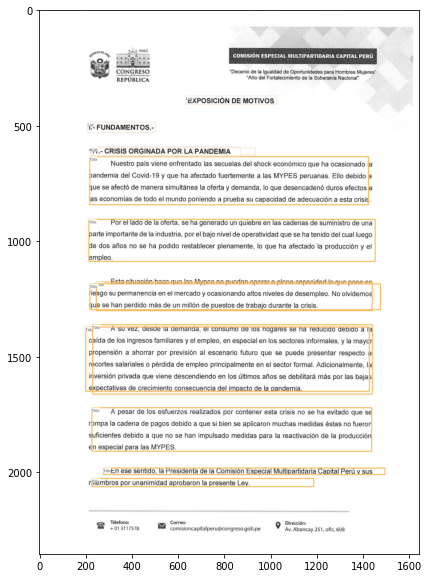

In [ ]:
img_predicted=lp.draw_box(bgr, layout, box_width=5, show_element_type=True)
plt.figure(figsize=(10,10))
plt.imshow(img_predicted)
plt.show()

In [ ]:
def get_min_max(b,x=True):
  if x:
    x1=b.coordinates[0]
    x2=b.coordinates[2]
  else:
    x1=b.coordinates[1]
    x2=b.coordinates[3]
    
  x_min = min(x1,x2)
  x_max = max(x1,x2)
  return x_min,x_max

def is_in_ver(b1,b2):
  y1_min,y1_max =get_min_max(b1, x=False)
  y2_min,y2_max =get_min_max(b2, x=False) 
  return (y2_min<y1_min) and (y1_max<y2_max)

def intersection_area(b1,b2):
  x1_min,x1_max =get_min_max(b1)
  x2_min,x2_max =get_min_max(b2)
  y1_min,y1_max =get_min_max(b1, x=False)
  y2_min,y2_max =get_min_max(b2, x=False)

  left = max(x1_min, x2_min);
  right = min(x1_max, x2_max);
  if left>right:
    return False

  top = max(y1_min, y2_min);
  bottom = min(y1_max, y2_max);

  if top>bottom:
    return False

  per_inter1 = abs(top - bottom)/abs(y1_max-y1_min)
  per_inter2 = abs(top - bottom)/abs(y2_max-y2_min)
  per_inter = max(per_inter1,per_inter2)
  return per_inter>0.7 or abs(top - bottom)>50

def is_in_list_vert(b1,blocks):
  is_in_v = [is_in_ver(b1,b) for b in blocks]
  return any(is_in_v)

def is_in_list_intersection_area(b1,blocks):
  is_in_v = [intersection_area(b1,b) for b in blocks]
  if any(is_in_v):
    index = is_in_v.index(True)
    return True,index
  else:
    return False,-1


def is_in_list(b1,blocks):
  pad = 30
  soft_margin={'left':pad,'right':pad,'top':pad,'bottom':pad}
  is_in = [b1.is_in(b, soft_margin=soft_margin) for b in blocks]

  if any(is_in):
    index = is_in.index(True)
    return True,index
  else:
    return False,-1
  


def merge_blocks(blocks):
  no_intersetctions = True
  new_blocks=[]
  for i,b in enumerate(blocks):

    is_in = is_in_list_vert(b,new_blocks)
    if is_in:
      no_intersetctions=False
      continue

    is_in,index = is_in_list_intersection_area(b,new_blocks)
    if is_in:
      new_blocks[index]=new_blocks[index].union(b)#, inplace=True)
      no_intersetctions=False
      continue

    new_blocks.append(b)
  return new_blocks , no_intersetctions

In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type in ['Text','Title','List']])
text_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
while 1:
  text_blocks,no_intersetctions = merge_blocks(text_blocks)
  if no_intersetctions:
    break

text_blocks = lp.Layout(text_blocks)
text_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

[True] 0


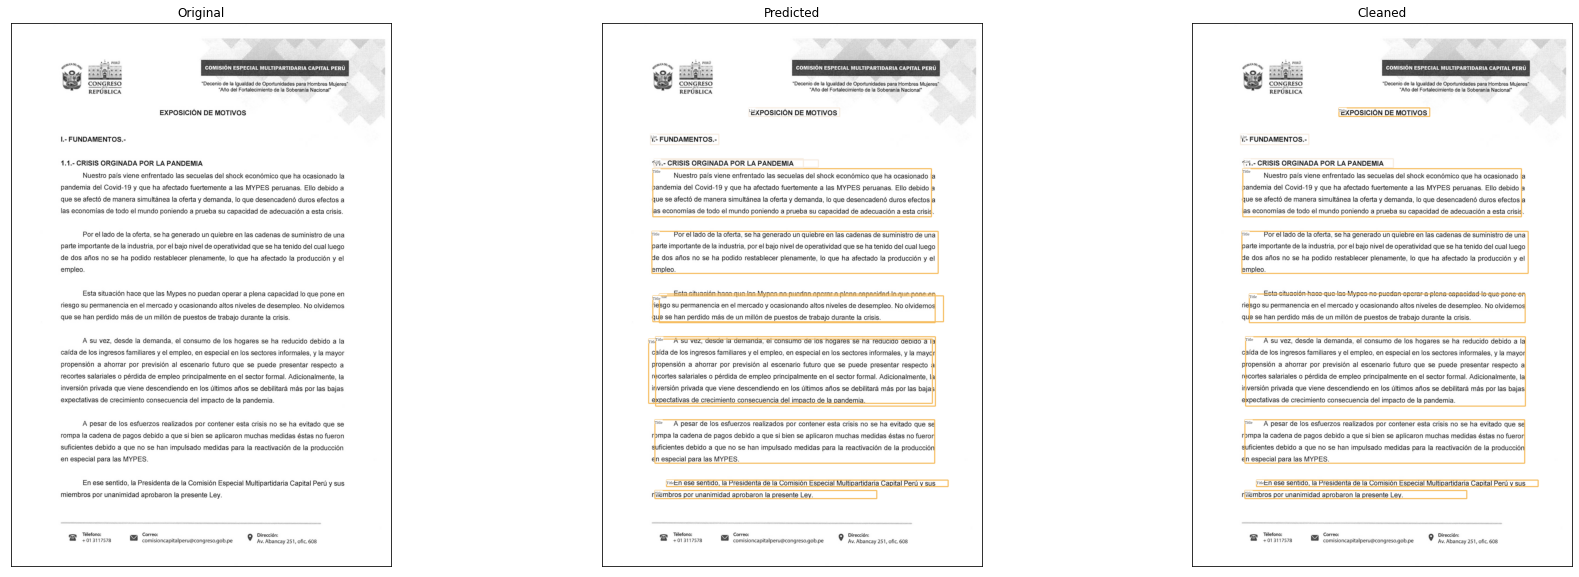

In [ ]:
img_cleaned = lp.draw_box(bgr, text_blocks, box_width=5, show_element_type=True)
fig,axes=plt.subplots(1,3,figsize=(30,10))
axes[0].imshow(bgr)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title('Original')
axes[1].imshow(img_predicted)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title('Predicted')
axes[2].imshow(img_cleaned)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title('Cleaned')
plt.show()

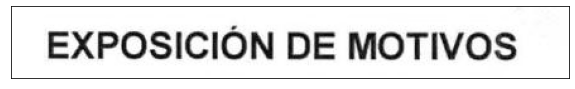

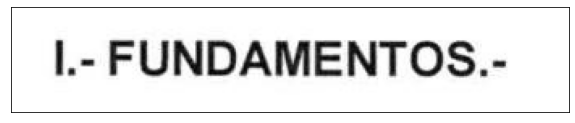

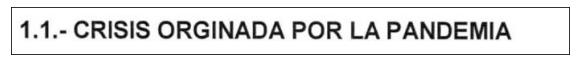

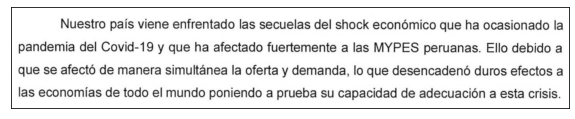

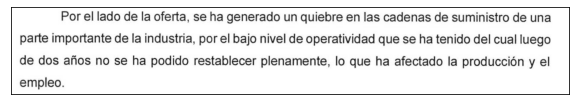

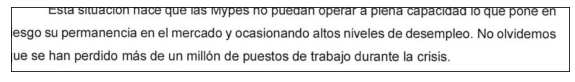

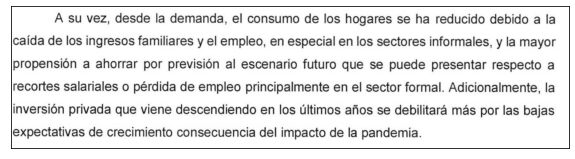

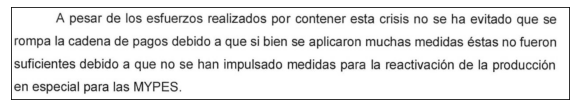

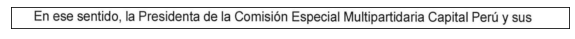

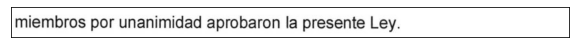

In [ ]:
import matplotlib.pyplot as plt

for block in text_blocks:
    segment_image = (block
                       .pad(left=20, right=30, top=10, bottom=10)
                       .crop_image(bgr))
    
    plt.figure(figsize=(10,5))
    plt.imshow(segment_image)
    plt.xticks([])
    plt.yticks([])

In [ ]:
ocr_agent = lp.TesseractAgent(languages='spa')

In [ ]:
import matplotlib.pyplot as plt

for block in text_blocks:
    segment_image = (block
                       .pad(left=20, right=30, top=10, bottom=10)
                       .crop_image(image))
    
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

EXPOSICIÓN DE MOTIVOS

---
l.- FUNDAMENTOS.-

---
1.1.- CRISIS ORGINADA POR LA PANDEMIA

---
Nuestro país viene enfrentado las secuelas del shock económico que ha ocasionado la
pandemia del Covid-19 y que ha afectado fuertemente a las MYPES peruanas. Ello debido a
que se afectó de manera simultánea la oferta y demanda, lo que desencadenó duros efectos a
las economías de todo el mundo poniendo a prueba su capacidad de adecuación a esta crisis.

---
Por el lado de la oferta, se ha generado un quiebre en las cadenas de suministro de una
parte importante de la industria, por el bajo nivel de operatividad que se ha tenido del cual luego
de dos años no se ha podido restablecer plenamente, lo que ha afectado la producción y el
empleo.

---
ESta situación nace que las IWypes no puedan operar a piena capacidad lo que pone en
lesgo su permanencia en el mercado y ocasionando altos niveles de desempleo. No olvidemos

jue se han perdido más de un millón de puestos de trabajo durante la crisis.

---

In [ ]:
type(text_blocks)

layoutparser.elements.layout.Layout

In [ ]:
df = text_blocks.to_dataframe()
df

,x_1,y_1,x_2,y_2,block_type,text,id,type,score
0,634.952026,371.491821,1026.438965,408.741821,rectangle,EXPOSICIÓN DE MOTIVOS\n,0,Title,0.294605
1,209.905334,485.286621,504.722382,530.309937,rectangle,l.- FUNDAMENTOS.-\n,0,List,0.297971
2,225.635452,591.889038,869.267288,630.103943,rectangle,1.1.- CRISIS ORGINADA POR LA PANDEMIA\n,0,List,0.327160
3,219.912415,634.573364,1422.627747,842.642273,rectangle,Nuestro país viene enfrentado las secuelas del...,0,Title,0.428134
4,215.854385,905.959106,1451.893936,1087.924805,rectangle,"Por el lado de la oferta, se ha generado un qu...",0,Title,0.541260
5,247.102982,1176.591675,1438.774490,1300.885498,rectangle,ESta situación nace que las IWypes no puedan o...,0,Title,0.279270
6,231.143677,1361.253174,1439.595825,1661.974731,rectangle,"A su vez, desde la demanda, el consumo de los ...",0,Title,0.634706
7,228.529144,1720.014038,1436.238495,1908.409546,rectangle,A pesar de los esfuerzos realizados por conten...,0,Title,0.549829
8,278.357056,1981.514404,1494.592651,2009.714722,rectangle,"En ese sentido, la Presidenta de la Comisión E...",0,Title,0.263890
9,228.483704,2026.051636,1186.916870,2061.940430,rectangle,miembros por unanimidad aprobaron la presente ...,0,Title,0.262993


In [ ]:
df.to_excel('output.xlsx')

In [ ]:
from glob import glob
from tqdm import tqdm
img_paths = sorted(glob("PL_2483/out_*.jpg"), key=lambda x: int(x.split('/')[1].split('_')[1].split('.')[0]))

texts = []
for img_path in tqdm(img_paths):
  image = cv2.imread(img_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

  layout=[]
  for m in [model0,model2]:
    layout += m.detect(bgr)

  text_blocks = lp.Layout([b for b in layout if b.type in ['Text','Title','List']])
  text_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
  while 1:
    text_blocks,no_intersetctions = merge_blocks(text_blocks)
    if no_intersetctions:
      break

  text_blocks = lp.Layout(text_blocks)
  text_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

  import matplotlib.pyplot as plt

  for block in text_blocks:
      segment_image = (block
                        .pad(left=20, right=30, top=10, bottom=10)
                        .crop_image(image))
      
      text = ocr_agent.detect(segment_image)
      block.set(text=text, inplace=True)

  texts+=[txt for txt in text_blocks.get_texts()]

  0%|          | 0/14 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/effdet/bench.py:55: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes
  7%|▋         | 1/14 [00:15<03:18, 15.24s/it]/usr/local/lib/python3.7/dist-packages/effdet/bench.py:55: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='flo

In [ ]:
with open('output.txt','w+') as file:
  file.write('\n'.join(texts))